In [2]:
#простая линейная регрессия 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

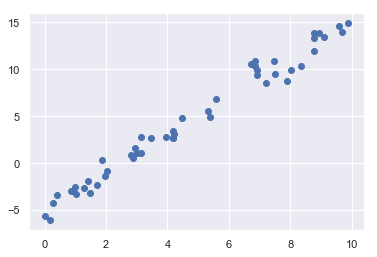

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2* x - 5 + rng.randn(50)
plt.scatter(x, y);

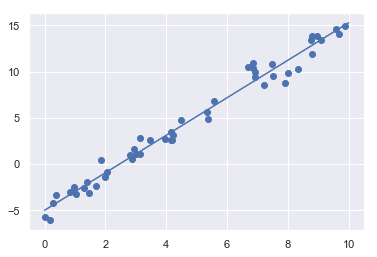

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [5]:
#узнаем пересечение (интерсепт) и угл. коэф:
print("Угловой коэффициент: ", model.coef_[0])
print("ордината пересечения с осью: ", model.intercept_)

Угловой коэффициент:  2.027208810360695
ордината пересечения с осью:  -4.998577085553202


In [6]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X , [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000144
[ 1.5 -2.   1. ]


In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [8]:
#полиномиальная модель 7ого порядка
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

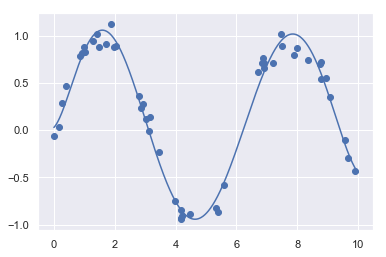

In [9]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

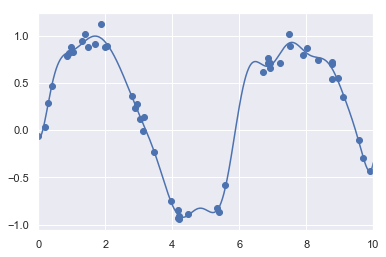

In [10]:
#гауссовы базисные функции

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Равномерно распределенные Гауссовы признаки
        для одномерных входных данных"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

    
    
    
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())

gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

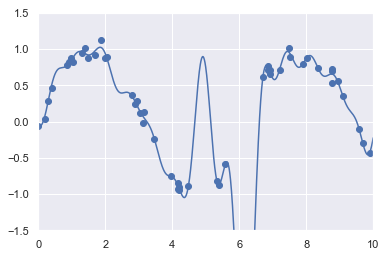

In [11]:
#можно отметить, что базисные функции гибки, но больше их кол-во приводит к быстрому переобучению
model = make_pipeline(GaussianFeatures(30), LinearRegression())

model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0,10)
plt.ylim(-1.5, 1.5);
#пример переобучения

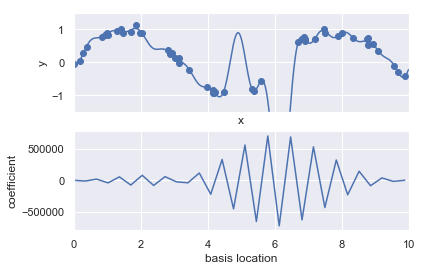

In [12]:
#модел с 30мерным базисом оказалась слишком гибкой и стремится к экстремальным значениям в тех местах, где нету данных
#построим график коэффициенотов Гауссовых базисных функций и определим причину
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location', ylabel='coefficient', xlim=(0,10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

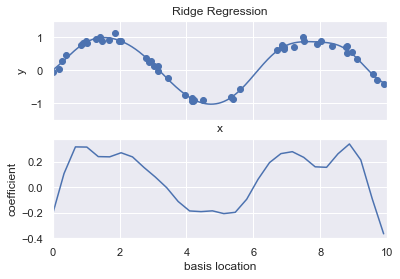

In [13]:
#гребневая регрессия (L2 - регуляция)
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression') # Гребневая регрессия


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


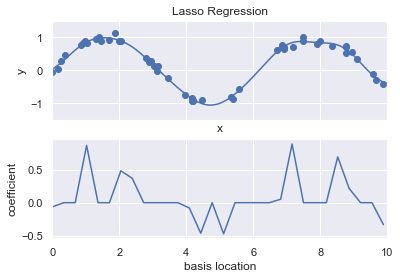

In [14]:
#лассо- регуляция (L1)
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')


In [15]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [16]:
daily = counts.resample('d', how='sum')
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [17]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)


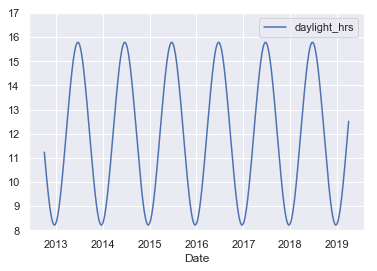

In [19]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Рассчитываем длительность светового для для заданной даты"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))*np.tan(np.radians(axis)) * np.cos(days * 2 * np.pi / 365.25))
    return 24. * np.degrees(np.arccos(1-np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();
plt.ylim(8, 17);

In [20]:
# Температуры указаны в десятых долях градуса Цельсия
# преобразуем в градусы
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp C'] = 0.5 * (weather['TMIN']+ weather['TMAX'])


#осадки указаны в десятых долях миллиметра рт ст; преобразуем в дюймы
weather['PRCP'] /= 254
weather['dry day']  = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp C', 'dry day']])

In [21]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [22]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp C,dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.235903,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.174662,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.113613,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.052770,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.992150,0.0,15.85,1.0,0.010959


In [30]:
column_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun','holiday','daylight_hrs','PRCP','Temp C','dry day','annual']

X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

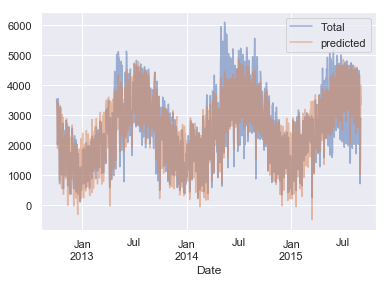

In [32]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [34]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              530.784391
Tue              636.195026
Wed              618.725836
Thu              508.368221
Fri              203.984985
Sat            -1077.270642
Sun            -1107.552815
holiday        -1186.955982
daylight_hrs     126.590636
PRCP            -665.188564
Temp C            65.319358
dry day          547.392502
annual            26.536071
dtype: float64

In [35]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
             for i in range(1000)], 0)

In [37]:
print(pd.DataFrame({'effect': params.round(0),
                   'error': err.round(0)}))

              effect  error
Mon            531.0   85.0
Tue            636.0   82.0
Wed            619.0   82.0
Thu            508.0   84.0
Fri            204.0   80.0
Sat          -1077.0   78.0
Sun          -1108.0   82.0
holiday      -1187.0  164.0
daylight_hrs   127.0    9.0
PRCP          -665.0   63.0
Temp C          65.0    4.0
dry day        547.0   33.0
annual          27.0   18.0
